In [6]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import sounddevice as sd

In [7]:
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import layers
from tensorflow.keras import models

In [8]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [9]:
tf_records = ["data/raw/" + filename for filename in os.listdir("./data/raw")]
tf_records

['data/raw/nsynth-test.tfrecord-00000-of-00008',
 'data/raw/nsynth-test.tfrecord-00001-of-00008',
 'data/raw/nsynth-test.tfrecord-00002-of-00008',
 'data/raw/nsynth-test.tfrecord-00003-of-00008',
 'data/raw/nsynth-test.tfrecord-00004-of-00008',
 'data/raw/nsynth-test.tfrecord-00005-of-00008',
 'data/raw/nsynth-test.tfrecord-00006-of-00008',
 'data/raw/nsynth-test.tfrecord-00007-of-00008']

In [10]:
raw_dataset = tf.data.TFRecordDataset(tf_records)
raw_dataset

<TFRecordDatasetV2 element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [11]:
info = pd.DataFrame(columns=["instrument_family", "instrument_source", "instrument", "pitch", "note"])
audio = []
for raw_record in raw_dataset.take(-1):
  example = tf.train.Example()
  example.ParseFromString(raw_record.numpy())
  row = [ 
    example.features.feature["instrument_family"].int64_list.value[0],
    example.features.feature["instrument_source"].int64_list.value[0],
    example.features.feature["instrument"].int64_list.value[0],
    example.features.feature["pitch"].int64_list.value[0],
    example.features.feature["note"].int64_list.value[0] 
  ]
  info.loc[len(info)] = row
  audio.append(example.features.feature["audio"].float_list.value)

In [12]:
audio = np.array(audio)
sr = 16000
sd.play(audio[4], sr)

In [13]:
info_train = info[:3072]
info_test = info[3072:]
audio_train = audio[:3072]
audio_test = audio[3072:]

In [14]:
sources = ["acoustic", "electronic", "synthetic"]
families = ["bass", "brass", "flute", "guitar", "keyboard", "mallet", "organ", "reed", "string", "synth_lead", "vocal"]

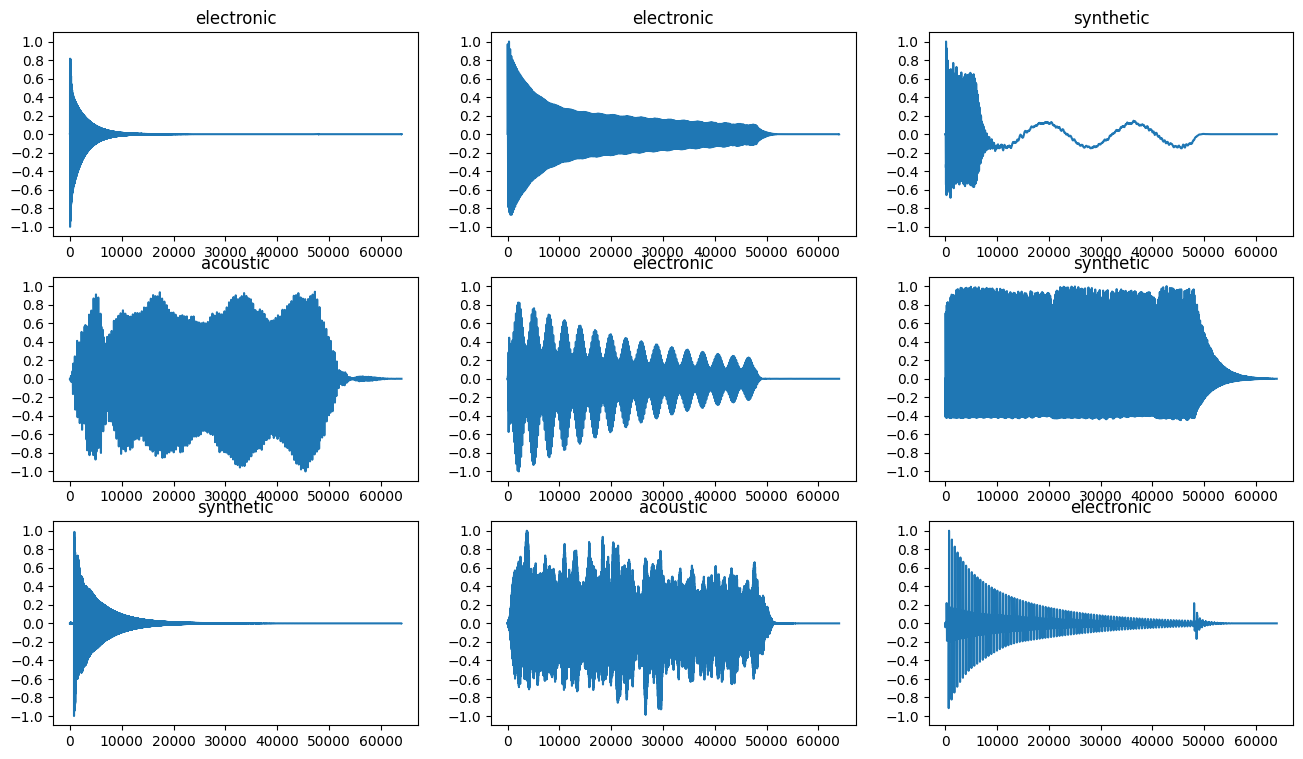

In [15]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
  if i>=n:
    break
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio_train[i])
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = sources[info_train["instrument_source"][i]]
  ax.set_title(label)
  ax.set_ylim([-1.1,1.1])

plt.show()

In [16]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [17]:
for i in range(3):
  label = sources[info_train["instrument_source"][i]]
  waveform = audio_train[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: electronic
Waveform shape: [-0.00047861  0.00050362 -0.00052697 ...  0.00040957 -0.00043103
  0.00045413]
Spectrogram shape: (499, 129, 1)
Audio playback


Label: electronic
Waveform shape: [ 0.00324829  0.00546618  0.00534806 ... -0.00014253  0.00020793
 -0.00037871]
Spectrogram shape: (499, 129, 1)
Audio playback


Label: synthetic
Waveform shape: [-0.00014757  0.00014822 -0.00014887 ...  0.00014566 -0.00014629
  0.00014693]
Spectrogram shape: (499, 129, 1)
Audio playback


In [18]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

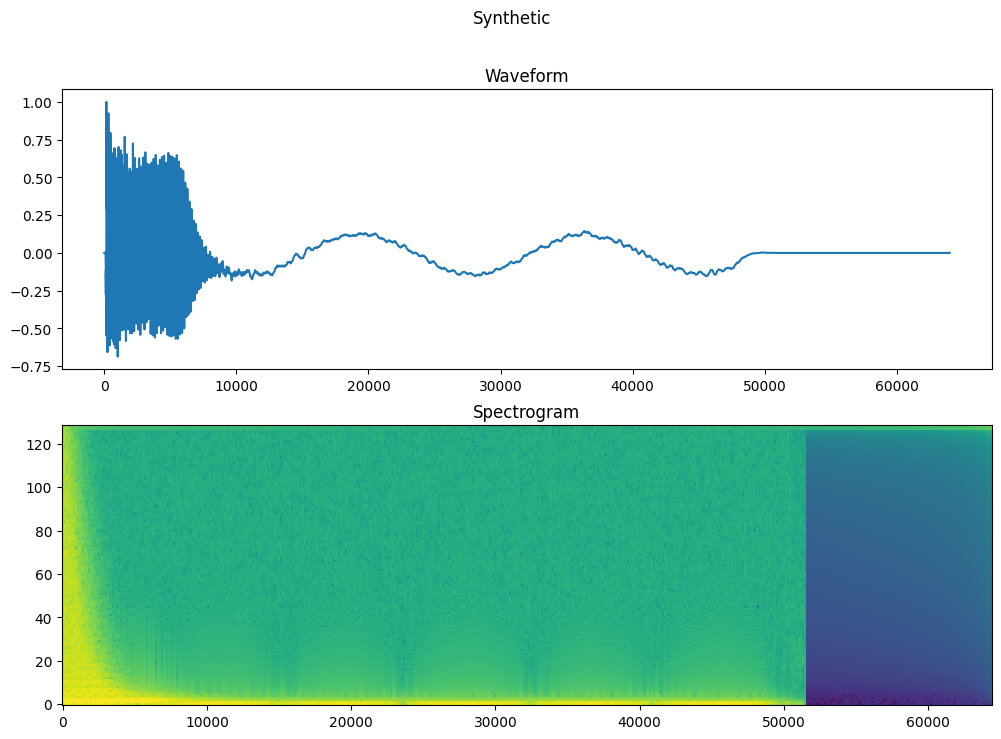

In [19]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
# axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [20]:
spectrograms_train = [get_spectrogram(waveform) for waveform in audio_train]
spectrograms_test = [get_spectrogram(waveform) for waveform in audio_test]

In [21]:
labels_train = info_train["instrument_source"].to_list()
labels_test = info_test["instrument_source"].to_list()

In [22]:
spectrograms_train = tf.convert_to_tensor(spectrograms_train)
spectrograms_test = tf.convert_to_tensor(spectrograms_test)
labels_train = tf.convert_to_tensor(labels_train)
labels_test = tf.convert_to_tensor(labels_test)

In [23]:
print(spectrograms_train.shape)
print(labels_train.shape)
print(spectrograms_test.shape)
print(labels_test.shape)

(3072, 499, 129, 1)
(3072,)
(1024, 499, 129, 1)
(1024,)


In [48]:
input_shape = spectrograms_train.shape[1:]
print('Input shape:', input_shape)
num_labels = len(sources)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrograms_train)

model = models.Sequential([
    layers.Input(shape=(None, None, 1)),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (499, 129, 1)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_2 (Normalizat  (None, 32, 32, 1)        3         
 ion)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)       

In [49]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [58]:
EPOCHS = 20
history = model.fit(
    x=spectrograms_train,
    y=labels_train,
    validation_data=(spectrograms_test, labels_test),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
96/96 [==============================] - 2s 14ms/step - loss: 0.3219 - accuracy: 0.8727 - val_loss: 0.3595 - val_accuracy: 0.8613
Epoch 2/20
96/96 [==============================] - 1s 12ms/step - loss: 0.2977 - accuracy: 0.8890 - val_loss: 0.3365 - val_accuracy: 0.8809
Epoch 3/20
96/96 [==============================] - 1s 12ms/step - loss: 0.2727 - accuracy: 0.8919 - val_loss: 0.3449 - val_accuracy: 0.8818
Epoch 4/20
96/96 [==============================] - 1s 12ms/step - loss: 0.2656 - accuracy: 0.9030 - val_loss: 0.2881 - val_accuracy: 0.9004
Epoch 5/20
96/96 [==============================] - 1s 12ms/step - loss: 0.2331 - accuracy: 0.9092 - val_loss: 0.3155 - val_accuracy: 0.9023
Epoch 6/20
96/96 [==============================] - 1s 12ms/step - loss: 0.2424 - accuracy: 0.9137 - val_loss: 0.2984 - val_accuracy: 0.9023
Epoch 6: early stopping


Text(0, 0.5, 'Accuracy [%]')

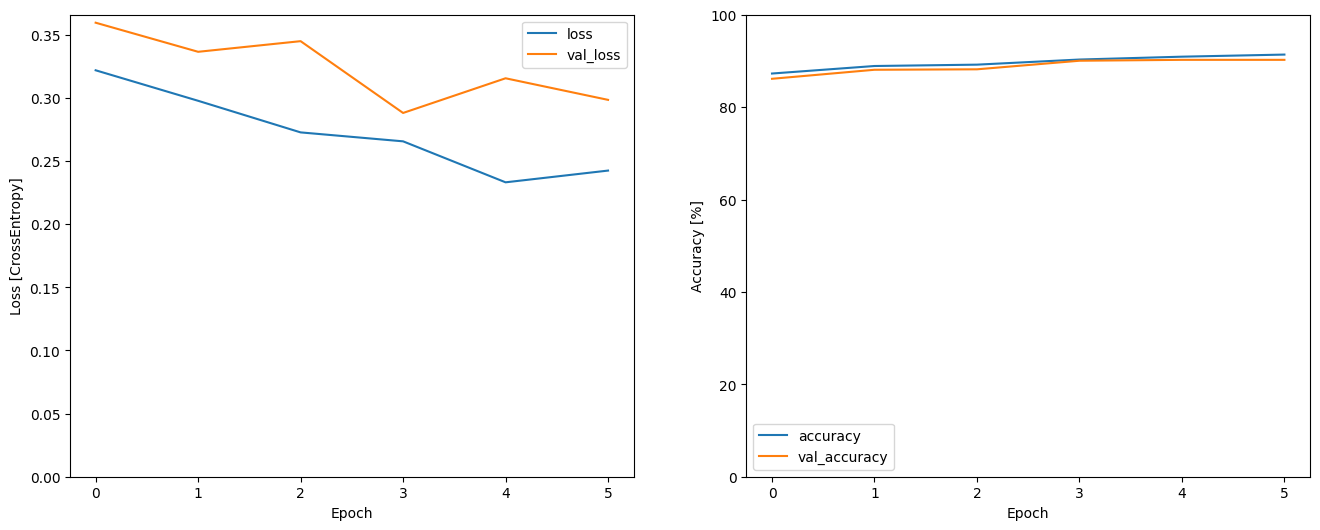

In [59]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [60]:
model.save("./models/model1")

INFO:tensorflow:Assets written to: ./models/model1\assets


INFO:tensorflow:Assets written to: ./models/model1\assets


In [61]:
model = tf.keras.models.load_model("./models/model1")

In [62]:
x = tf.io.read_file("./piano-G3.wav")
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

In [63]:
prediction = model(x)

In [64]:
prediction

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[ 0.860001  ,  0.1342126 , -0.85429704]], dtype=float32)>

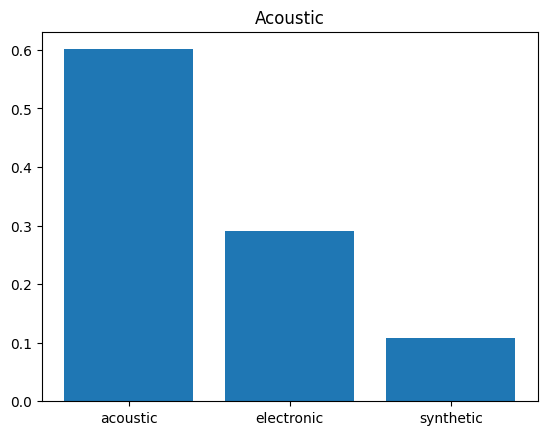

In [65]:
plt.bar(sources, tf.nn.softmax(prediction[0]))
plt.title('Acoustic')
plt.show()

display.display(display.Audio(waveform, rate=16000))